# Yelp Dataset Analysis - Pub Ratings

In [52]:
import csv
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import operator #need this for sorting dicts later
import matplotlib.cm as cm #for colormapping later
from matplotlib.colors import LogNorm
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
%matplotlib inline

Import custom restauramt and not_restaurant csv files as dataframes

In [53]:
not_restaurant_df = pd.read_csv('not_restaurant.csv')
not_restaurant_df = not_restaurant_df.drop(['Unnamed: 0','city','distance'], 1)
not_restaurant_df = not_restaurant_df.drop_duplicates(subset=['name','postal_code','latitude','longitude','neighborhood'], keep=False)
pubs_df = pd.read_csv('pubs.csv')
pubs_df = pubs_df.drop(['city','Unnamed: 0'], 1)
pubs_df = pubs_df.drop_duplicates(subset=['name','postal_code','latitude','longitude','neighborhood'], keep=False)
pubs_df['index_no'] = pubs_df.index
pubs_df.head()

,name,postal_code,latitude,longitude,neighborhood,categories,stars,review_count,index_no
0,McCarthy's Irish Pub,M4L 2B5,43.678049,-79.314774,Upper Beach,"[u'Pubs', u'Restaurants', u'Bars', u'Irish', u...",4.0,5,0
1,Boardwalk Place,M4W 3L6,43.663010,-79.310898,NaN,"[u'American (Traditional)', u'Restaurants', u'...",3.0,13,1
2,The Yellow Griffin,M6S 1N4,43.651439,-79.475629,Bloor-West Village,"[u'Pubs', u'Restaurants', u'Burgers', u'Nightl...",3.0,98,2
3,Cabin Fever,M6P 1A6,43.655350,-79.456719,High Park,"[u'Cafes', u'Art Galleries', u'Arts & Entertai...",4.5,26,3
4,Bar Homestand,M6G 1M2,43.662600,-79.423726,Christie Pits,"[u'Comfort Food', u'Pubs', u'Bars', u'Sports B...",3.5,5,4


In [54]:
not_restaurant_df.describe()

,latitude,longitude,stars,review_count
count,3738.000000,3738.000000,3738.000000,3738.000000
mean,43.659746,-79.390947,3.702381,12.928571
std,0.863939,0.454143,0.979130,24.914754
min,-9.095137,-79.653939,1.000000,3.000000
25%,43.649911,-79.419545,3.000000,4.000000
50%,43.662539,-79.395460,4.000000,6.000000
75%,43.680457,-79.378843,4.500000,13.000000
max,43.844762,-51.833829,5.000000,530.000000


In [55]:
pubs_df.describe()

,latitude,longitude,stars,review_count,index_no
count,203.000000,203.000000,203.000000,203.000000,203.000000
mean,43.668998,-79.388099,3.391626,63.502463,186.078818
std,0.032415,0.057959,0.580695,101.331891,90.279454
min,43.599790,-79.603882,2.000000,3.000000,0.000000
25%,43.650502,-79.414682,3.000000,16.500000,112.500000
50%,43.660418,-79.390206,3.500000,33.000000,187.000000
75%,43.673362,-79.363302,4.000000,71.500000,269.500000
max,43.796148,-79.170583,4.500000,1087.000000,347.000000


In [56]:
final_businesses_df = pd.DataFrame()

def haversine(x):
    
    global not_restaurant_df
    global final_businesses_df
    
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
    
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(not_restaurant_df['latitude']), np.radians(not_restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    not_restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   # print("4. pubs gets a new distace col", pubs_df)
    
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = not_restaurant_df
   # print("5. Another new dataframe is init, it equals pubs_df", measure_1)
    measure_1 = measure_1.loc[(not_restaurant_df['distance'] > 0.0) & (not_restaurant_df['distance'] <=1.0)]
    #print("Measure_1 is now", measure_1)
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    #print("mean biz rating is calc", mean_rating)
    density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    final_businesses_df = final_businesses_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, "density": density}, ignore_index=True)
    return final_businesses_df


for line in pubs_df['index_no']:
    x = pubs_df.loc[pubs_df['index_no'] == line]
    haversine(x)


## Relationship Between Pub Rating and Non Pub Business Density

We are interested in looking at the relationship between pub ratings and the density of non pub businesses around each pub. To further divide our dataset, we say that any area with less than or equal to 30 businesses are low density areas while anything above 30 businesses are high density areas.

In [57]:
## Initialize a DF to store pubs that have a density of less than or equal to
## 30 non-pub and non-restaurant businesses around them
low_density_df = pd.DataFrame()
low_density_df = final_businesses_df.loc[final_businesses_df['density'] <= 30]

In [58]:
## Initialize a DF to store pubs that have a density of more than
## 30 non-pub and non-restaurant businesses around them
high_density_df = pd.DataFrame()
high_density_df = final_businesses_df.loc[final_businesses_df['density'] > 30]

Now we can generate a scatterplot with density of non-pub businesses on the x axis and the ratings of pubs on the Y axis to see if any relationship exists.

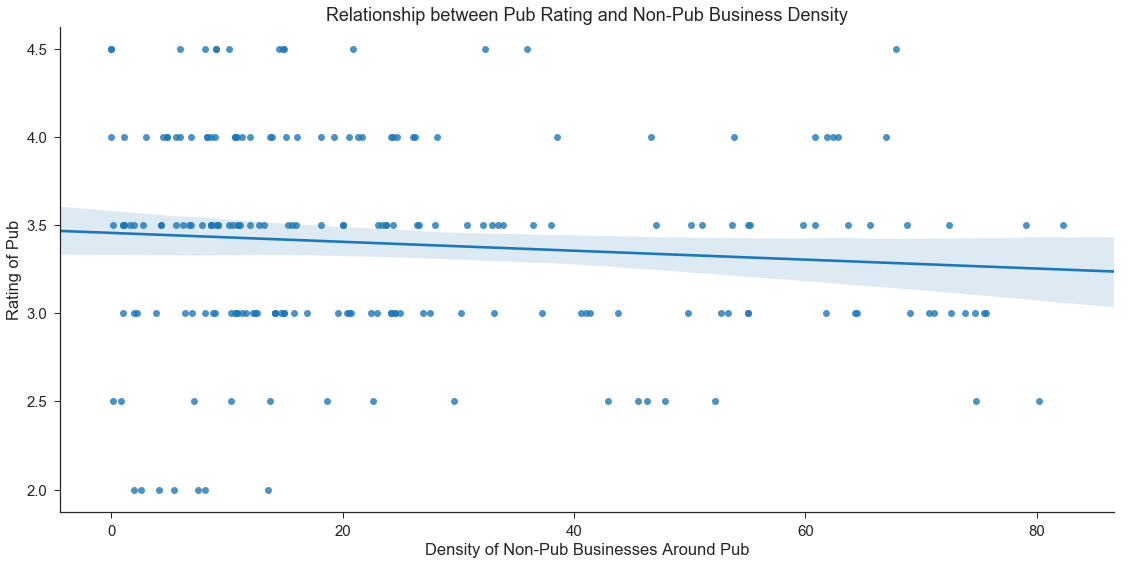

In [59]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="density", y="rating", size=8, data=final_businesses_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Pub Rating and Non-Pub Business Density")
plt.xlabel('Density of Non-Pub Businesses Around Pub')
plt.ylabel('Rating of Pub')

It seems from the above graph that there is no definite relationship between ratings of pubs and density of businesses. Infact. there seem to be more higher and lower rating pubs in low density areas as compared to high density areas in Toronto.

## Rating of a Pub Based on the Ratings of Other Pubs Around It

In [60]:
final_pubs_df = pd.DataFrame()

def haversine(x):
    
    global pubs_df
    global final_pubs_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
    
    print("our x df inside haversine func is", x)
    
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(pubs_df['latitude']), np.radians(pubs_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    pubs_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   # print("4. pubs gets a new distace col", pubs_df)
    
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = pubs_df
   # print("5. Another new dataframe is init, it equals pubs_df", measure_1)
    measure_1 = measure_1.loc[(pubs_df['distance'] > 0.0) & (pubs_df['distance'] <=1.0)]
    #print("Measure_1 is now", measure_1)
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    #print("mean biz rating is calc", mean_rating)
    density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    final_pubs_df = final_pubs_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, "density": density}, ignore_index=True)
    return final_pubs_df


for line in pubs_df['index_no']:
    x = pubs_df.loc[pubs_df['index_no'] == line]
    print("The line of the DataFrame is", x)
    haversine(x)




The line of the DataFrame is                    name postal_code   latitude  longitude neighborhood  \
0  McCarthy's Irish Pub     M4L 2B5  43.678049 -79.314774  Upper Beach   

                                          categories  stars  review_count  \
0  [u'Pubs', u'Restaurants', u'Bars', u'Irish', u...    4.0             5   

   index_no  
0         0  
our x df inside haversine func is                    name postal_code   latitude  longitude neighborhood  \
0  McCarthy's Irish Pub     M4L 2B5  43.678049 -79.314774  Upper Beach   

                                          categories  stars  review_count  \
0  [u'Pubs', u'Restaurants', u'Bars', u'Irish', u...    4.0             5   

   index_no  
0         0  
The line of the DataFrame is               name postal_code  latitude  longitude neighborhood  \
1  Boardwalk Place     M4W 3L6  43.66301 -79.310898          NaN   

                                          categories  stars  review_count  \
1  [u'American (Traditional)',

The line of the DataFrame is                       name postal_code   latitude  longitude  \
72  The Bishop And Belcher     M4W 3R8  43.670305 -79.382288   

                neighborhood  \
72  Church-Wellesley Village   

                                           categories  stars  review_count  \
72  [u'British', u'Restaurants', u'Nightlife', u'B...    3.5            72   

    index_no  distance  
72        72   1.79294  
our x df inside haversine func is                       name postal_code   latitude  longitude  \
72  The Bishop And Belcher     M4W 3R8  43.670305 -79.382288   

                neighborhood  \
72  Church-Wellesley Village   

                                           categories  stars  review_count  \
72  [u'British', u'Restaurants', u'Nightlife', u'B...    3.5            72   

    index_no  distance  
72        72   1.79294  
The line of the DataFrame is             name postal_code  latitude  longitude neighborhood  \
73  Victory Café     M6G 2L7  43.66376 -

82        82   5.58835  
The line of the DataFrame is                     name postal_code   latitude  longitude neighborhood  \
83  Gabby's Roncesvalles     M6R 2L3  43.644004 -79.448139    High Park   

                                           categories  stars  review_count  \
83  [u'Nightlife', u'Burgers', u'Restaurants', u'S...    2.5             9   

    index_no  distance  
83        83  3.026502  
our x df inside haversine func is                     name postal_code   latitude  longitude neighborhood  \
83  Gabby's Roncesvalles     M6R 2L3  43.644004 -79.448139    High Park   

                                           categories  stars  review_count  \
83  [u'Nightlife', u'Burgers', u'Restaurants', u'S...    2.5             9   

    index_no  distance  
83        83  3.026502  
The line of the DataFrame is               name postal_code   latitude  longitude neighborhood  \
84  Round the Horn     M6R 2M8  43.649194 -79.449944    High Park   

                            

94        94  7.827346  
The line of the DataFrame is               name postal_code   latitude  longitude neighborhood  \
95  The Grover Pub     M4E 1R4  43.679123 -79.297149  Upper Beach   

                                           categories  stars  review_count  \
95  [u'Food', u'Restaurants', u'Comfort Food', u'B...    3.0            16   

    index_no  distance  
95        95  11.39112  
our x df inside haversine func is               name postal_code   latitude  longitude neighborhood  \
95  The Grover Pub     M4E 1R4  43.679123 -79.297149  Upper Beach   

                                           categories  stars  review_count  \
95  [u'Food', u'Restaurants', u'Comfort Food', u'B...    3.0            16   

    index_no  distance  
95        95  11.39112  
The line of the DataFrame is               name postal_code   latitude  longitude  neighborhood  \
104  The Only Cafe     M4J 1L9  43.680469 -79.337862  The Danforth   

                                            catego

The line of the DataFrame is              name postal_code   latitude  longitude neighborhood  \
114  The Old Nick     M4K 1N2  43.676234 -79.357776    Riverdale   

                                            categories  stars  review_count  \
114  [u'Breakfast & Brunch', u'Pubs', u'Music Venue...    3.0            34   

     index_no  distance  
114       114   4.08572  
our x df inside haversine func is              name postal_code   latitude  longitude neighborhood  \
114  The Old Nick     M4K 1N2  43.676234 -79.357776    Riverdale   

                                            categories  stars  review_count  \
114  [u'Breakfast & Brunch', u'Pubs', u'Music Venue...    3.0            34   

     index_no  distance  
114       114   4.08572  
The line of the DataFrame is                      name postal_code   latitude  longitude  neighborhood  \
115  The Hole In the Wall     M6P 1Y9  43.665337 -79.465149  The Junction   

                                            categories  s

The line of the DataFrame is          name postal_code   latitude  longitude  neighborhood  \
133  Pour Boy     M6G 1B2  43.655321 -79.413309  Little Italy   

                                            categories  stars  review_count  \
133  [u'Bars', u'American (Traditional)', u'Restaur...    4.0            11   

     index_no  distance  
133       133  1.218344  
our x df inside haversine func is          name postal_code   latitude  longitude  neighborhood  \
133  Pour Boy     M6G 1B2  43.655321 -79.413309  Little Italy   

                                            categories  stars  review_count  \
133  [u'Bars', u'American (Traditional)', u'Restaur...    4.0            11   

     index_no  distance  
133       133  1.218344  
The line of the DataFrame is                            name postal_code   latitude  longitude  \
134  Scruffy Murphy's Irish Pub     M4P 1E8  43.708009 -79.393628   

                      neighborhood  \
134  Mount Pleasant and Davisville   

        

The line of the DataFrame is                       name postal_code   latitude  longitude   neighborhood  \
144  O'Grady's Tap & Grill     M5T 1P7  43.658889   -79.3938  Downtown Core   

                                            categories  stars  review_count  \
144  [u'Bars', u'Irish', u'Nightlife', u'Restaurant...    2.5            32   

     index_no  distance  
144       144  5.538574  
our x df inside haversine func is                       name postal_code   latitude  longitude   neighborhood  \
144  O'Grady's Tap & Grill     M5T 1P7  43.658889   -79.3938  Downtown Core   

                                            categories  stars  review_count  \
144  [u'Bars', u'Irish', u'Nightlife', u'Restaurant...    2.5            32   

     index_no  distance  
144       144  5.538574  
The line of the DataFrame is                      name postal_code  latitude  longitude neighborhood  \
145  Brass Taps Pizza Pub     M5A 2L2  43.66403 -79.369119  Cabbagetown   

                 

The line of the DataFrame is            name postal_code   latitude  longitude neighborhood  \
164  Joker Cafe     M6K 3H6  43.634444 -79.425603     Parkdale   

                                            categories  stars  review_count  \
164  [u'Pubs', u'Restaurants', u'Barbeque', u'Moder...    3.5            10   

     index_no   distance  
164       164  14.813437  
our x df inside haversine func is            name postal_code   latitude  longitude neighborhood  \
164  Joker Cafe     M6K 3H6  43.634444 -79.425603     Parkdale   

                                            categories  stars  review_count  \
164  [u'Pubs', u'Restaurants', u'Barbeque', u'Moder...    3.5            10   

     index_no   distance  
164       164  14.813437  
The line of the DataFrame is            name postal_code   latitude  longitude  neighborhood  \
165  C'est What     M5E 1B5  43.648511 -79.373409  St. Lawrence   

                                            categories  stars  review_count  \
16

175       175  15.229803  
our x df inside haversine func is                   name postal_code   latitude  longitude neighborhood  \
175  Muckish Irish Pub     M1L 4B2  43.720041 -79.284063  Scarborough   

                                            categories  stars  review_count  \
175  [u'Restaurants', u'Beer', u'Wine & Spirits', u...    3.5             8   

     index_no   distance  
175       175  15.229803  
The line of the DataFrame is                         name postal_code   latitude  longitude neighborhood  \
176  St James's Gate Toronto     M9A 1C2  43.643811 -79.533577    Etobicoke   

                                            categories  stars  review_count  \
176  [u'Restaurants', u'Bars', u'Pubs', u'Food', u'...    4.0            48   

     index_no  distance  
176       176  22.68914  
our x df inside haversine func is                         name postal_code   latitude  longitude neighborhood  \
176  St James's Gate Toronto     M9A 1C2  43.643811 -79.533577    E

our x df inside haversine func is           name postal_code   latitude  longitude neighborhood  \
194  Quigley's     M4E 1E9  43.672633 -79.287634    The Beach   

                                            categories  stars  review_count  \
194  [u'Nightlife', u'Pubs', u'Restaurants', u'Bars...    4.0             8   

     index_no  distance  
194       194  9.928456  
The line of the DataFrame is            name postal_code   latitude  longitude neighborhood  \
195  The Sister     M6R 1A6  43.640029 -79.439945     Parkdale   

                                            categories  stars  review_count  \
195  [u'Music Venues', u'Restaurants', u'Breakfast ...    3.5            57   

     index_no   distance  
195       195  13.350066  
our x df inside haversine func is            name postal_code   latitude  longitude neighborhood  \
195  The Sister     M6R 1A6  43.640029 -79.439945     Parkdale   

                                            categories  stars  review_count  \
195

our x df inside haversine func is                            name postal_code   latitude  longitude  \
205  Chimac Pub & Fried Chicken     M5V 2B6  43.647938 -79.401254   

       neighborhood                                         categories  stars  \
205  Alexandra Park  [u'Pubs', u'Chicken Wings', u'Bars', u'Nightli...    3.5   

     review_count  index_no  distance  
205            31       205  1.026133  
The line of the DataFrame is                 name postal_code   latitude  longitude   neighborhood  \
214  The Bottom Line     M5J 1C4  43.646521  -79.37788  Downtown Core   

                                            categories  stars  review_count  \
214  [u'Steakhouses', u'Nightlife', u'Bars', u'Amer...    3.0            30   

     index_no  distance  
214       214  1.978039  
our x df inside haversine func is                 name postal_code   latitude  longitude   neighborhood  \
214  The Bottom Line     M5J 1C4  43.646521  -79.37788  Downtown Core   

                

our x df inside haversine func is           name postal_code   latitude  longitude  neighborhood  \
248  Burgatory     M6G 1C2  43.655055 -79.418563  Little Italy   

                                            categories  stars  review_count  \
248  [u'Pubs', u'Burgers', u'Food Trucks', u'Nightl...    3.0             9   

     index_no  distance  
248       248  15.35445  
The line of the DataFrame is                         name postal_code   latitude  longitude neighborhood  \
249  Whelan's Gate Irish Pub     M6P 1A6  43.655419 -79.456505    High Park   

                                            categories  stars  review_count  \
249  [u'Restaurants', u'Nightlife', u'Irish', u'Pub...    3.5            27   

     index_no  distance  
249       249  3.200683  
our x df inside haversine func is                         name postal_code   latitude  longitude neighborhood  \
249  Whelan's Gate Irish Pub     M6P 1A6  43.655419 -79.456505    High Park   

                              

258       258  5.848594  
The line of the DataFrame is                      name postal_code   latitude  longitude  \
259  Mill Street Brew Pub     M5A 3C4  43.650442 -79.358443   

            neighborhood                                         categories  \
259  Distillery District  [u'Food', u'Bars', u'Pubs', u'Breweries', u'Br...   

     stars  review_count  index_no  distance  
259    3.5           359       259  5.495785  
our x df inside haversine func is                      name postal_code   latitude  longitude  \
259  Mill Street Brew Pub     M5A 3C4  43.650442 -79.358443   

            neighborhood                                         categories  \
259  Distillery District  [u'Food', u'Bars', u'Pubs', u'Breweries', u'Br...   

     stars  review_count  index_no  distance  
259    3.5           359       259  5.495785  
The line of the DataFrame is                       name postal_code   latitude  longitude   neighborhood  \
260  Overdraught Irish Pub     M5J 2L6  43.

270       270  12.786836  
our x df inside haversine func is                      name postal_code   latitude  longitude  neighborhood  \
270  Axis Gallery & Grill     M6P 1Z3  43.665586 -79.470838  The Junction   

                                            categories  stars  review_count  \
270  [u'Restaurants', u'Nightlife', u'Bars', u'Gast...    3.0            28   

     index_no   distance  
270       270  12.786836  
The line of the DataFrame is                       name postal_code   latitude  longitude neighborhood  \
271  The Station Ale House     M6S 1P7  43.649005 -79.484616      Swansea   

                                            categories  stars  review_count  \
271  [u'Restaurants', u'Gastropubs', u'Nightlife', ...    4.5             6   

     index_no  distance  
271       271  2.178544  
our x df inside haversine func is                       name postal_code   latitude  longitude neighborhood  \
271  The Station Ale House     M6S 1P7  43.649005 -79.484616     

our x df inside haversine func is                          name postal_code  latitude  longitude  neighborhood  \
282  Tilted Kilt Pub & Eatery     M5E 1A1  43.64693 -79.374978  St. Lawrence   

                                            categories  stars  review_count  \
282  [u'Chicken Wings', u'Sports Bars', u'Nightlife...    2.5            64   

     index_no  distance  
282       282  1.476205  
The line of the DataFrame is             name postal_code   latitude  longitude neighborhood  \
283  The Citizen     M5V 1K4  43.645304 -79.397621          NaN   

                                            categories  stars  review_count  \
283  [u'Nightlife', u'Cocktail Bars', u'Comfort Foo...    3.0            55   

     index_no  distance  
283       283  1.918647  
our x df inside haversine func is             name postal_code   latitude  longitude neighborhood  \
283  The Citizen     M5V 1K4  43.645304 -79.397621          NaN   

                                            catego

293       293  4.611731  
The line of the DataFrame is                     name postal_code   latitude  longitude     neighborhood  \
294  LOCAL Public Eatery     M6K 3P6  43.638715 -79.418539  Liberty Village   

                                            categories  stars  review_count  \
294  [u'Bars', u'Nightlife', u'Restaurants', u'Brea...    4.0           187   

     index_no  distance  
294       294   8.51328  
our x df inside haversine func is                     name postal_code   latitude  longitude     neighborhood  \
294  LOCAL Public Eatery     M6K 3P6  43.638715 -79.418539  Liberty Village   

                                            categories  stars  review_count  \
294  [u'Bars', u'Nightlife', u'Restaurants', u'Brea...    4.0           187   

     index_no  distance  
294       294   8.51328  
The line of the DataFrame is                 name postal_code   latitude  longitude neighborhood  \
295  The Underground     M3J 1P3  43.774084 -79.502381          NaN   


The line of the DataFrame is                name postal_code   latitude  longitude neighborhood  \
305  The Green Wood     M4L 1C9  43.664756 -79.324295  Leslieville   

                                            categories  stars  review_count  \
305  [u'Bars', u'Breakfast & Brunch', u'Restaurants...    4.0            15   

     index_no  distance  
305       305  7.631937  
our x df inside haversine func is                name postal_code   latitude  longitude neighborhood  \
305  The Green Wood     M4L 1C9  43.664756 -79.324295  Leslieville   

                                            categories  stars  review_count  \
305  [u'Bars', u'Breakfast & Brunch', u'Restaurants...    4.0            15   

     index_no  distance  
305       305  7.631937  
The line of the DataFrame is                     name postal_code   latitude  longitude neighborhood  \
306  Foggy Dew Irish Pub     M5V 1N4  43.642848 -79.407235      Niagara   

                                            categorie

In [70]:
final_pubs_df = final_pubs_df.fillna(value=0)

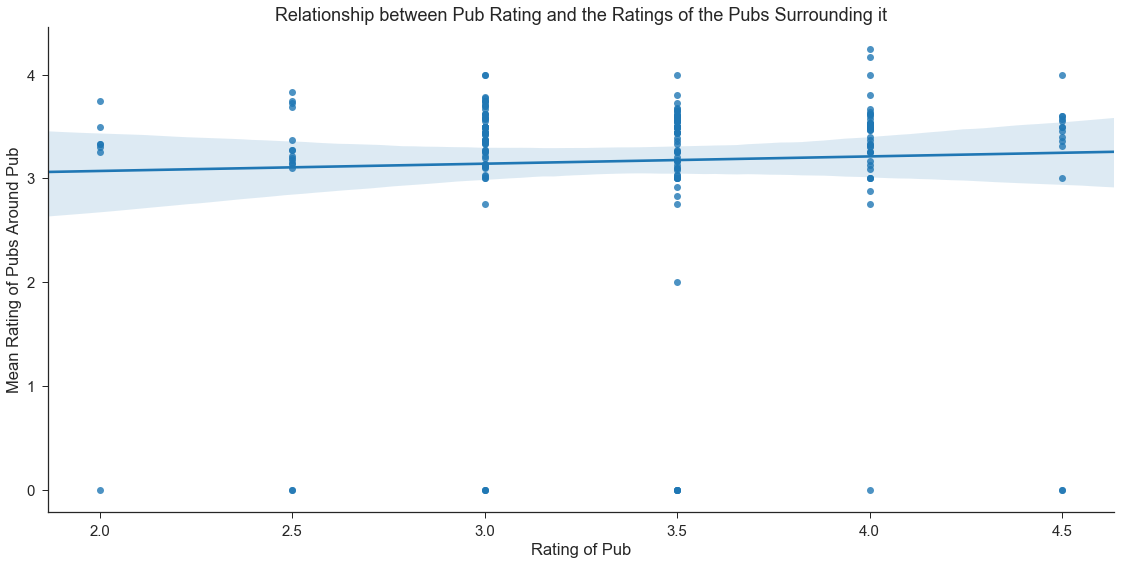

In [71]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="rating", y="mean_business_rating", size=8, data=final_pubs_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Pub Rating and the Ratings of the Pubs Surrounding it")
plt.xlabel('Rating of Pub')
plt.ylabel('Mean Rating of Pubs Around Pub')

In [72]:
final_pubs_df.head(10)

,density,mean_business_rating,name,rating
0,0.477465,4.166667,McCarthy's Irish Pub,4.0
1,0.000000,0.000000,Boardwalk Place,3.0
2,0.795775,3.700000,The Yellow Griffin,3.0
3,0.795775,3.600000,Cabin Fever,4.5
4,0.954930,3.666667,Bar Homestand,3.5
5,1.750704,3.590909,The Red Room,3.0
6,0.159155,4.000000,Scallywags,3.0
7,2.546479,3.343750,The 3 Brewers,3.0
8,0.159155,3.500000,McSorley's Wonderful Saloon & Grill,3.5
9,0.954930,3.166667,Duke of Kent,3.5


In [ ]:
#rating of pub quality vs rating non-pub density
